# Part-1

## Dataset Downloading

In [17]:
!pip install -q kaggle

# Upload your kaggle.json (from your Kaggle account > Account > API > Create New Token)
from google.colab import files
files.upload()  # upload kaggle.json

# Move it to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [18]:
# Download the dataset
!kaggle datasets download -d jessicali9530/lfw-dataset

# Unzip to /content/lfw
!unzip -q lfw-dataset.zip -d /content/lfw_extracted


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other
 73% 82.0M/112M [00:00<00:00, 858MB/s]
100% 112M/112M [00:00<00:00, 721MB/s] 


In [19]:
import os

print("Top level:", os.listdir("/content"))
print("Inside /content/lfw_extracted:", os.listdir("/content/lfw_extracted"))


Top level: ['.config', 'student_data.zip', 'student_data (1).zip', 'kaggle.json', 'lfw-dataset.zip', 'data', 'student_data', 'lfw_extracted', 'sample_data']
Inside /content/lfw_extracted: ['mismatchpairsDevTrain.csv', 'people.csv', 'peopleDevTrain.csv', 'matchpairsDevTest.csv', 'lfw_allnames.csv', 'mismatchpairsDevTest.csv', 'lfw-deepfunneled', 'matchpairsDevTrain.csv', 'pairs.csv', 'peopleDevTest.csv', 'lfw_readme.csv']


In [20]:
lfw_path = "/content/lfw_extracted/lfw-deepfunneled/lfw-deepfunneled"


In [21]:
import os, shutil
from tqdm import tqdm
import random

lfw_path = "/content/lfw_extracted/lfw-deepfunneled/lfw-deepfunneled"  # ✅ updated path
train_path = '/content/data/train'
test_path = '/content/data/test'
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

for person in tqdm(os.listdir(lfw_path)):
    person_dir = os.path.join(lfw_path, person)
    images = os.listdir(person_dir)

    if len(images) < 2:
        continue

    random.shuffle(images)
    train_img = images[0]
    test_imgs = images[1:]

    os.makedirs(os.path.join(train_path, person), exist_ok=True)
    os.makedirs(os.path.join(test_path, person), exist_ok=True)

    shutil.copy(os.path.join(person_dir, train_img),
                os.path.join(train_path, person, train_img))

    for img in test_imgs:
        shutil.copy(os.path.join(person_dir, img),
                    os.path.join(test_path, person, img))


100%|██████████| 5749/5749 [00:02<00:00, 2201.75it/s]


In [22]:
!ls /content/data/train | wc -l  # total people in train
!ls /content/data/test | wc -l   # total people in test
!find /content/data/train -type f | wc -l  # total training images
!find /content/data/test -type f | wc -l   # total test images


1680
1680
1680
7484


## Embedding and Matching

In [1]:
!pip uninstall -y pillow facenet-pytorch


Found existing installation: facenet-pytorch 2.5.2
Uninstalling facenet-pytorch-2.5.2:
  Successfully uninstalled facenet-pytorch-2.5.2


In [2]:
!pip install pillow==10.1 facenet-pytorch==2.5.2


  Using cached Pillow-10.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.5 kB)
  Using cached facenet_pytorch-2.5.2-py3-none-any.whl.metadata (12 kB)
Using cached Pillow-10.1.0-cp311-cp311-manylinux_2_28_x86_64.whl (3.6 MB)
Using cached facenet_pytorch-2.5.2-py3-none-any.whl (1.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.1 which is incompatible.


In [1]:
# Uninstall existing versions of torchvision and Pillow
!pip uninstall -y torchvision pillow

# Install compatible versions
!pip install torchvision==0.16.2+cu121 pillow==9.5.0

# Reinstall facenet-pytorch (this might be necessary to pick up the new dependencies)
!pip install facenet-pytorch==2.5.2

Found existing installation: torchvision 0.22.1
Uninstalling torchvision-0.22.1:
  Successfully uninstalled torchvision-0.22.1
Found existing installation: pillow 11.3.0
Uninstalling pillow-11.3.0:
  Successfully uninstalled pillow-11.3.0
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.16.2+cu121 (from versions: 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.20.0, 0.20.1, 0.21.0, 0.22.0, 0.22.1)
ERROR: No matching distribution found for torchvision==0.16.2+cu121
  Using cached torchvision-0.22.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached pillow-11.3.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (9.0 kB)
Using cached pillow-11.3.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (6.6 MB)
Using cached torchvision-0.22.1

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import torch


In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import torch
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize MTCNN (for face detection) and InceptionResnetV1 (for embeddings)
mtcnn = MTCNN(image_size=160, margin=0, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)


In [3]:
train_dir = "/content/data/train"
train_embeddings = []
train_names = []

print("Extracting train embeddings...")

for person in tqdm(os.listdir(train_dir)):
    person_dir = os.path.join(train_dir, person)
    images = os.listdir(person_dir)

    if len(images) == 0:
        continue  # Skip folders with no images

    image_path = os.path.join(person_dir, images[0])
    img = Image.open(image_path)
    face = mtcnn(img)

    if face is not None:
        with torch.no_grad():
            emb = resnet(face.unsqueeze(0).to(device)).cpu().squeeze(0)
            train_embeddings.append(emb)
            train_names.append(person)


Extracting train embeddings...


100%|██████████| 1680/1680 [06:43<00:00,  4.17it/s]


In [5]:
test_dir = "/content/data/test"
predicted_names = []
true_names = []

print("Matching test images...")

for person in tqdm(os.listdir(test_dir)):
    person_dir = os.path.join(test_dir, person)

    for image_name in os.listdir(person_dir):
        image_path = os.path.join(person_dir, image_name)
        img = Image.open(image_path)
        face = mtcnn(img)

        if face is not None:
            with torch.no_grad():
                emb = resnet(face.unsqueeze(0).to(device)).cpu().squeeze(0)

            # Compute cosine similarities to all train embeddings
            similarities = [torch.nn.functional.cosine_similarity(emb, train_emb, dim=0).item()
                            for train_emb in train_embeddings]
            best_match_index = np.argmax(similarities)

            predicted_names.append(train_names[best_match_index])
            true_names.append(person)


Matching test images...


100%|██████████| 1680/1680 [37:46<00:00,  1.35s/it]



🔍 Accuracy: 0.8927

🧾 Classification Report:
                                 precision    recall  f1-score   support

                  Aaron_Peirsol       1.00      1.00      1.00         3
                   Aaron_Sorkin       1.00      1.00      1.00         1
            Abdel_Nasser_Assidi       1.00      1.00      1.00         1
                 Abdoulaye_Wade       1.00      0.67      0.80         3
                       Abdullah       1.00      1.00      1.00         3
                   Abdullah_Gul       0.85      0.94      0.89        18
            Abdullah_al-Attiyah       1.00      1.00      1.00         2
               Abdullatif_Sener       1.00      1.00      1.00         1
                   Abel_Pacheco       1.00      1.00      1.00         3
   Abid_Hamid_Mahmud_Al-Tikriti       0.50      1.00      0.67         2
                   Adam_Sandler       1.00      0.33      0.50         3
                     Adam_Scott       0.00      0.00      0.00         1
    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


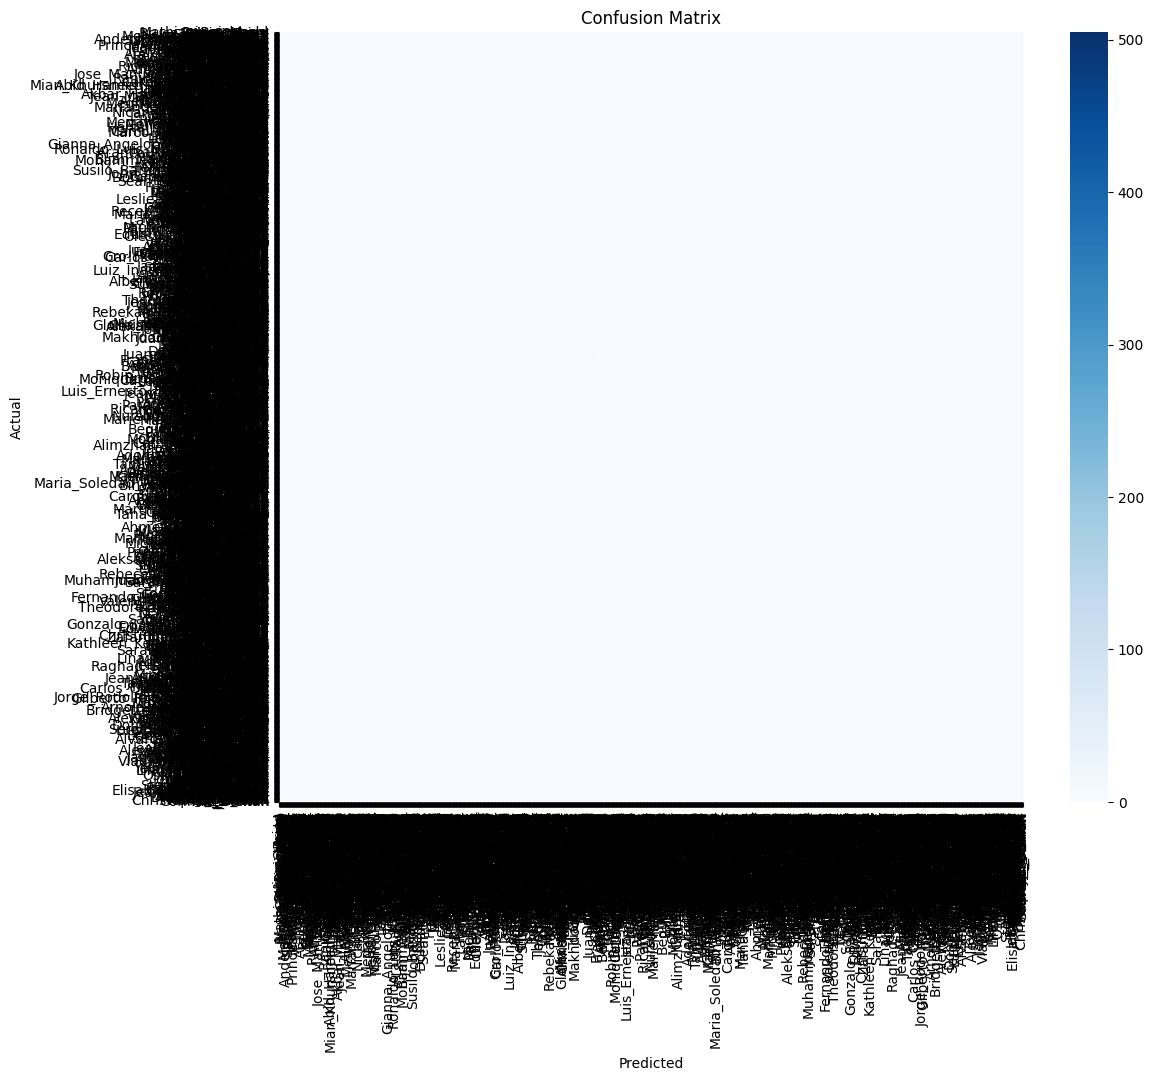

In [ ]:
# Overall accuracy
acc = accuracy_score(true_names, predicted_names)
print(f"\n Accuracy: {acc:.4f}")

# Classification report
print("\n Classification Report:")
print(classification_report(true_names, predicted_names))

# Confusion matrix
cm = confusion_matrix(true_names, predicted_names, labels=train_names)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=train_names, yticklabels=train_names, annot=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
for i in range(min(10, len(true_names))):
    print(f" True: {true_names[i]} → Predicted: {predicted_names[i]}")


🔍 True: Prince_Harry → Predicted: Prince_Harry
🔍 True: Prince_Harry → Predicted: Prince_Harry
🔍 True: Mathias_Reichhold → Predicted: Mathias_Reichhold
🔍 True: Mathias_Reichhold → Predicted: Mark_Warner
🔍 True: Jim_OBrien → Predicted: Valdas_Adamkus
🔍 True: Jim_OBrien → Predicted: Jim_OBrien
🔍 True: Bruce_Springsteen → Predicted: Bruce_Springsteen
🔍 True: Bruce_Springsteen → Predicted: Bruce_Springsteen
🔍 True: Bruce_Springsteen → Predicted: Bruce_Springsteen
🔍 True: Bob_Graham → Predicted: Bob_Graham


# Part-2

## WebScraped Data of Student Pics

In [4]:
from google.colab import files
uploaded = files.upload()  # Choose the ZIP file


Saving student_data.zip to student_data (1).zip


In [5]:
!unzip student_data.zip


Streaming output truncated to the last 5000 lines.
  inflating: student_data/images/231040055.jpg  
  inflating: student_data/images/231040057.jpg  
  inflating: student_data/images/231040058.jpg  
  inflating: student_data/images/231040059.jpg  
  inflating: student_data/images/231040060.jpg  
  inflating: student_data/images/231040061.jpg  
  inflating: student_data/images/231040062.jpg  
  inflating: student_data/images/231040063.jpg  
  inflating: student_data/images/231040064.jpg  
  inflating: student_data/images/231040065.jpg  
  inflating: student_data/images/231040066.jpg  
  inflating: student_data/images/231040067.jpg  
  inflating: student_data/images/231040069.jpg  
  inflating: student_data/images/231040071.jpg  
  inflating: student_data/images/231040072.jpg  
  inflating: student_data/images/231040073.jpg  
  inflating: student_data/images/231040074.jpg  
  inflating: student_data/images/231040076.jpg  
  inflating: student_data/images/231040077.jpg  
  inflating: stude

## name of the matching person

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import torch
import os
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load Face Detection and Recognition Models
mtcnn = MTCNN(image_size=160, margin=0)
resnet = InceptionResnetV1(pretrained='vggface2').eval()

# Paths
image_dir = "student_data/images"
csv_path = "student_data/students_100_with_images_20250708_104339.csv"

# Load CSV
df = pd.read_csv(csv_path)
print(" CSV loaded with", len(df), "students.")


✅ CSV loaded with 15066 students.


In [ ]:
from PIL import UnidentifiedImageError

# Store embeddings and names
embeddings = []
names = []

print("🔍 Extracting embeddings from training images...")

for idx, row in df.iterrows():
    img_path = row['image_path']
    name = row['name']

    #  Skip if image_path is NaN or invalid
    if not isinstance(img_path, str) or img_path.strip().lower() == 'nan' or not os.path.exists(img_path):
        print(f" Skipping invalid image path at row {idx}: {img_path}")
        continue

    try:
        with Image.open(img_path).convert("RGB") as img:
            face = mtcnn(img)

            if face is not None:
                with torch.no_grad():
                    embedding = resnet(face.unsqueeze(0)).squeeze().numpy()
                    embeddings.append(embedding)
                    names.append(name)
            else:
                print(f" Face not detected in {img_path}")

    except UnidentifiedImageError:
        print(f" Unreadable or corrupt image at {img_path}")
    except Exception as e:
        print(f" Error processing {img_path}: {e}")

print(f" Extracted {len(embeddings)} embeddings.")


🔍 Extracting embeddings from training images...
❌ Skipping invalid image path at row 84: nan
❌ Skipping invalid image path at row 85: nan
❌ Skipping invalid image path at row 86: nan
❌ Skipping invalid image path at row 88: nan
❌ Skipping invalid image path at row 93: nan
❌ Skipping invalid image path at row 126: nan
❌ Skipping invalid image path at row 206: nan
❌ Skipping invalid image path at row 207: nan
❌ Skipping invalid image path at row 208: nan
❌ Skipping invalid image path at row 211: nan
❌ Skipping invalid image path at row 212: nan
❌ Skipping invalid image path at row 217: nan
❌ Skipping invalid image path at row 218: nan
❌ Skipping invalid image path at row 219: nan
❌ Skipping invalid image path at row 220: nan
❌ Skipping invalid image path at row 347: nan
❌ Skipping invalid image path at row 348: nan
❌ Skipping invalid image path at row 349: nan
❌ Skipping invalid image path at row 350: nan
❌ Skipping invalid image path at row 351: nan
❌ Skipping invalid image path at row 

In [ ]:
# Load your test image (any JPEG file with a visible face)
test_image_path = "student_data/images/230709.jpg"  #  Replace with desired test image

img = Image.open(test_image_path)
face = mtcnn(img)

if face is not None:
    with torch.no_grad():
        test_embedding = resnet(face.unsqueeze(0)).squeeze().numpy()

    # Compute cosine similarity between test image and all student embeddings
    similarities = cosine_similarity([test_embedding], embeddings)[0]
    best_match_index = np.argmax(similarities)
    best_match_name = names[best_match_index]
    best_score = similarities[best_match_index]

    print(f" Best Match: {best_match_name} (Score: {best_score:.4f})")
else:
    print(" Face not detected in test image.")


✅ Best Match: Nithin T M (Score: 1.0000)
